# Fine-tune Detr

For this tutorial we will be working with the wheat dataset, available on kaggle [here](https://www.kaggle.com/c/global-wheat-detection).

## Dependencies

After installing Mantisshrimp ([instructions](https://lgvaz.github.io/mantisshrimp/readme_link.html#install)), install all the dependencies required by Detr ([instructions](https://github.com/facebookresearch/detr#usage)).

Also, install seaborn for visualizing logs:
```python
pip install seaborn
```

## Imports

Mantisshrimp is built in such a way that is safe to use wildcard imports,
.e.g. `from mantisshrimp import *`.

`from mantisshrimp.imports import *` will import commonly used packages like `np` and `plt`.

`from mantisshrimp import *` will import all mantis modules needed for development.

In [16]:
from mantisshrimp.imports import *
from mantisshrimp import *
from mantisshrimp.hub.detr import *
import pandas as pd

## Parser

This tutorial does not goes in detail on how to create a Parser, if you want to learn more, check the [Parser tutorial](https://lgvaz.github.io/mantisshrimp/tutorials/parser.html).

In [2]:
class WheatParser(DetrBBoxParser):
    def __init__(self, df, source):
        self.df = df
        self.source = source
        self.imageid_map = IDMap()

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def prepare(self, o):
        self.bbox = BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))

    def imageid(self, o) -> int:
        return self.imageid_map[o.image_id]

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def height(self, o) -> int:
        return o.height

    def width(self, o) -> int:
        return o.width

    def label(self, o) -> List[int]:
        return [1]

    def bbox(self, o) -> List[BBox]:
        return [self.bbox]

    def area(self, o) -> List[float]:
        return [self.bbox.area]

    def iscrowd(self, o) -> List[bool]:
        return [0]

## Dataset

Now we use our `Parser` to, well, parse our data!  

First, read the records into a dataframe.

<div class="alert alert-info">
    
**Note:**  

Replace `source` with your own path for the dataset directory.
    
</div>

In [3]:
source = Path("/home/lgvaz/.data/wheat")
df = pd.read_csv(source / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


Define what kind of train/validation split we want, in this case, let's make a random split with 80% of the data in the training set and 20% on the validation.

In [4]:
data_splitter = RandomSplitter([0.8, 0.2])

We are now ready to parse!

In [5]:
parser = WheatParser(df, source / "train")
train_rs, valid_rs = parser.parse(data_splitter)

Mantisshrimp is agnostic to transforms, so we will use the exact same transforms that the authors of Detr used (it's even from their code!).

In [6]:
train_tfm = detr_transform("train")
valid_tfm = detr_transform("val")

We create our `Dataset` as always, passing the records and the transforms.  

The only difference is that this time we're using the specialized `DetrDataset`.

In [7]:
train_dataset = DetrDataset(train_rs, train_tfm)
valid_dataset = DetrDataset(valid_rs, valid_tfm)

## Train

Now, just a little trick for using the original script (that uses argparse, meant for command line usage).

We'll parse the arguments passing an empty string, and then assign the values we want to modify one by one.

In [8]:
args_parser = get_args_parser()
args = args_parser.parse_args("")

In [9]:
args.num_classes = 2
args.epochs = 2
args.batch_size = 4
args.train_only_head = True

<div class="alert alert-info">
    
**Note:**  

Make sure `output_dir` exists, else we have errors.
    
</div>

In [10]:
output_dir = Path('logs/run1')
output_dir.mkdir(exist_ok=True, parents=True)
args.output_dir = str(output_dir)

<div class="alert alert-warning">
    
**Important:**  
    
For fine-tuning, we resume from a previous checkpoint where the weights of the class head have been deleted.
    
</div>

In [11]:
args.resume = detr_pretrained_checkpoint_base()

The final step is to call `run_detr` with the parsed args and the datasets.  

`run_detr` is just an alias that points to the original `main.py` script.

In [12]:
run_detr(args, train_dataset, valid_dataset)

## Plot logs

plot_utils.py::plot_logs info: logs param expects a list argument, converted to list[Path].


/home/lgvaz/git/mantisshrimp2/mantisshrimp/hub/detr/detr/util/plot_utils.py:68: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.DataFrame(pd.np.stack(col.dropna().values)[:, 1])


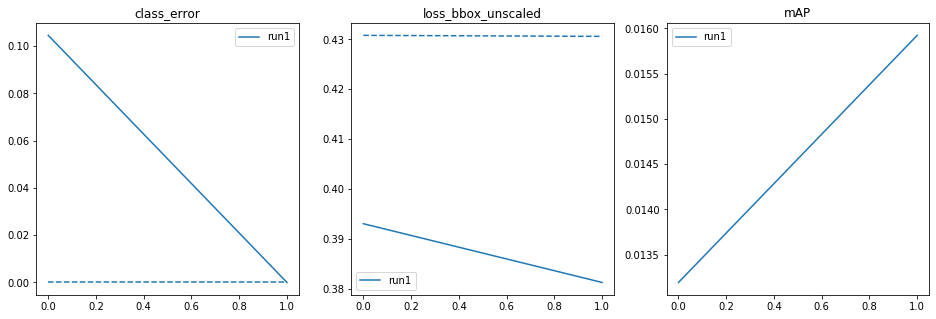

In [14]:
detr_plot_utils.plot_logs(output_dir, bbox_only=True)